# MTG SEA-AD Oligodendrocyte Analysis

This notebook analyzes oligodendrocyte data from the SEA-AD dataset, specifically focusing on the middle temporal gyrus (MTG) region and comparing different Braak stages.

## Objectives:
1. Load and inspect the OLIGO_MTG_SEA-AD.h5ad dataset
2. Check data normalization status
3. Filter for Braak stages: Reference, Braak III, and Braak VI
4. Perform standard Scanpy processing if needed
5. Analyze cluster composition by Braak stage
6. Perform differential gene expression analysis
7. Visualize results with volcano plots


In [1]:
# Import required libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for modern Jupyter notebook display
# Use plt.rcParams instead of deprecated IPython.display.set_matplotlib_formats
plt.rcParams['figure.autolayout'] = True  # Prevents label overlapping
plt.rcParams['figure.dpi'] = 150  # Higher DPI for better resolution
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size
plt.rcParams['savefig.format'] = 'png'  # Default save format
plt.rcParams['savefig.dpi'] = 300  # High resolution for saved figures
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Set scanpy settings without using deprecated set_figure_params
sc.settings.verbosity = 3  # verbosity level
# Configure scanpy settings manually to avoid deprecated IPython function calls
sc.settings._vector_friendly = False
sc.settings.dpi = 150  # Match matplotlib DPI
sc.settings.dpi_save = 300
sc.settings.frameon = True
sc.settings.fontsize = 12
sc.settings.figsize = (10, 6)
sc.settings.color_map = 'viridis'

# Load environment variables
load_dotenv()

print("Libraries imported successfully!")
print("Matplotlib and Scanpy configured for modern Jupyter display")


/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWar

Libraries imported successfully!
Matplotlib and Scanpy configured for modern Jupyter display


In [2]:
# Load data path from environment variables
data_path = os.getenv('DATA_PATH')
if data_path is None:
    raise ValueError("DATA_PATH not found in environment variables. Please check your .env file.")

# Construct the full path to the data file
data_file_path = os.path.join(data_path, 'OLIGO_MTG_SEA-AD.h5ad')

print(f"Data path loaded from environment")
print(f"Data file: OLIGO_MTG_SEA-AD.h5ad")

# Check if file exists
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"Data file not found at: {data_file_path}")

print("Data file found!")


Data path loaded from environment
Data file: OLIGO_MTG_SEA-AD.h5ad
Data file found!


In [3]:
# Load the AnnData object
print("Loading AnnData object...")
adata = sc.read_h5ad(data_file_path)

print(f"Dataset shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Display basic information about the dataset
print("\nDataset info:")
print(f"Obs (cells) columns: {list(adata.obs.columns)}")
print(f"Var (genes) columns: {list(adata.var.columns)}")

# Check if there are any uns keys
if adata.uns:
    print(f"Unstructured metadata keys: {list(adata.uns.keys())}")


Loading AnnData object...
Dataset shape: (111194, 36412)
Number of cells: 111194
Number of genes: 36412

Dataset info:
Obs (cells) columns: ['assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid']
Var (genes) columns: ['feature_is_filtered', 'feature_name', 'featur

## Data Normalization Check

We need to check whether the data is normalized and if raw data is available for processing.


In [4]:
# Check data normalization status
print("Checking data normalization status...")

# Check if raw data is available
has_raw = adata.raw is not None
print(f"Raw data available: {has_raw}")

# Check the main data matrix properties
print(f"\nMain data matrix:")
print(f"  - Data type: {type(adata.X)}")
print(f"  - Shape: {adata.X.shape}")
print(f"  - Data type of values: {adata.X.dtype if hasattr(adata.X, 'dtype') else 'Unknown'}")

# Check for normalized data in layers
print(f"\nAvailable layers: {list(adata.layers.keys())}")

# Check data distribution to infer normalization status
sample_data = adata.X[:1000, :1000].toarray() if hasattr(adata.X, 'toarray') else adata.X[:1000, :1000]
print(f"\nData statistics (sample of 1000x1000):")
print(f"  - Min: {np.min(sample_data):.2f}")
print(f"  - Max: {np.max(sample_data):.2f}")
print(f"  - Mean: {np.mean(sample_data):.2f}")
print(f"  - Median: {np.median(sample_data):.2f}")

# Determine if data appears to be normalized
is_normalized = np.max(sample_data) < 50 and np.mean(sample_data) < 10
print(f"\nData appears to be normalized: {is_normalized}")

# Store raw data if available and data is normalized
if has_raw and is_normalized:
    print("Raw count data is available and will be used for processing.")
    # Keep the current normalized data in X and raw in raw
elif not has_raw and not is_normalized:
    print("Data appears to be raw counts. Will proceed with normalization.")
    # This is raw count data, will need to normalize
else:
    print("Data status unclear. Will inspect further.")


Checking data normalization status...
Raw data available: True

Main data matrix:
  - Data type: <class 'scipy.sparse._csr.csr_matrix'>
  - Shape: (111194, 36412)
  - Data type of values: float32

Available layers: []

Data statistics (sample of 1000x1000):
  - Min: 0.00
  - Max: 4.73
  - Mean: 0.24
  - Median: 0.00

Data appears to be normalized: True
Raw count data is available and will be used for processing.


## Filter Data for Braak Stages

Filter the dataset to include only cells from Braak stages: Reference, Braak III, and Braak VI.


In [5]:
# Check available Braak stage information
print("Checking Braak stage information...")

# Look for Braak-related columns
braak_columns = [col for col in adata.obs.columns if 'braak' in col.lower() or 'stage' in col.lower()]
print(f"Braak-related columns found: {braak_columns}")

# Display unique values in Braak-related columns
for col in braak_columns:
    unique_vals = adata.obs[col].unique()
    print(f"\n{col} unique values:")
    print(unique_vals)
    print(f"Count per value:")
    print(adata.obs[col].value_counts())

# Also check for any other potential grouping columns
print(f"\nAll available obs columns:")
for col in adata.obs.columns:
    print(f"  - {col}: {len(adata.obs[col].unique())} unique values")


Checking Braak stage information...
Braak-related columns found: ['Braak stage', 'LATE-NC stage', 'development_stage_ontology_term_id', 'development_stage']

Braak stage unique values:
['Braak III', 'Braak IV', 'Braak V', 'Braak VI', 'Reference', 'Braak II', 'Braak 0']
Categories (7, object): ['Reference', 'Braak 0', 'Braak II', 'Braak III', 'Braak IV', 'Braak V', 'Braak VI']
Count per value:
Braak stage
Braak V      41996
Braak IV     38970
Braak VI     13285
Reference     5513
Braak III     4512
Braak II      3976
Braak 0       2942
Name: count, dtype: int64

LATE-NC stage unique values:
['LATE Stage 1', 'Not Identified', 'LATE Stage 2', 'Reference', 'LATE Stage 3', 'Staging Precluded by FTLD with TDP43 or ALS/M...]
Categories (6, object): ['Reference', 'Staging Precluded by FTLD with TDP43 or ALS/M..., 'Not Identified', 'LATE Stage 1', 'LATE Stage 2', 'LATE Stage 3']
Count per value:
LATE-NC stage
LATE Stage 2                                                                          

In [6]:
# Filter data for specific Braak stages
# Use the 'Braak stage' column specifically

# Define the exact Braak stages we want to keep
target_braak_stages = ["Reference", "Braak III", "Braak VI"]

# Use the specific 'Braak stage' column
braak_col = "Braak stage"
filtered_adata = adata.copy()

# Check if the 'Braak stage' column exists
if braak_col in adata.obs.columns:
    print(f"Using column '{braak_col}' for filtering")
    
    # Get unique values in the Braak stage column
    unique_vals = adata.obs[braak_col].unique()
    print(f"Available values in {braak_col}: {unique_vals}")
    
    # Find exact matches for our target stages
    matching_values = []
    for val in unique_vals:
        if str(val) in target_braak_stages:
            matching_values.append(val)
    
    if matching_values:
        print(f"Found matching values: {matching_values}")
        # Filter the data
        mask = adata.obs[braak_col].isin(matching_values)
        filtered_adata = adata[mask, :].copy()
        print(f"Filtered dataset shape: {filtered_adata.shape}")
        print(f"Original dataset shape: {adata.shape}")
        print(f"Cells removed: {adata.n_obs - filtered_adata.n_obs}")
        
        # Show distribution of remaining Braak stages
        print(f"\nDistribution after filtering:")
        print(filtered_adata.obs[braak_col].value_counts())
    else:
        print("No matching Braak stage values found. Keeping all data.")
        print("Available values:", unique_vals)
        print("Target values:", target_braak_stages)
else:
    print(f"Column '{braak_col}' not found in data.")
    print("Available Braak-related columns:", braak_columns)
    print("Available columns:", list(adata.obs.columns))

# Update adata to the filtered version
adata = filtered_adata


Using column 'Braak stage' for filtering
Available values in Braak stage: ['Braak III', 'Braak IV', 'Braak V', 'Braak VI', 'Reference', 'Braak II', 'Braak 0']
Categories (7, object): ['Reference', 'Braak 0', 'Braak II', 'Braak III', 'Braak IV', 'Braak V', 'Braak VI']
Found matching values: ['Braak III', 'Braak VI', 'Reference']
Filtered dataset shape: (23310, 36412)
Original dataset shape: (111194, 36412)
Cells removed: 87884

Distribution after filtering:
Braak stage
Braak VI     13285
Reference     5513
Braak III     4512
Name: count, dtype: int64


## Standard Scanpy Processing

If the data contains raw counts, perform standard Scanpy preprocessing steps.


In [ ]:
# Perform standard Scanpy processing if data appears to be raw counts
if not is_normalized or (has_raw and not is_normalized):
    print("Performing standard Scanpy preprocessing...")
    
    # Store raw data if not already stored
    if not has_raw:
        print("Storing raw count data...")
        adata.raw = adata
    
    # Basic filtering
    print("Calculating QC metrics...")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Filter genes and cells
    print("Filtering genes and cells...")
    # Filter genes that are expressed in fewer than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Filter cells that have fewer than 200 genes expressed
    sc.pp.filter_cells(adata, min_genes=200)
    
    # Remove cells with high mitochondrial gene expression
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Remove cells with >20% mitochondrial genes
    adata = adata[adata.obs.pct_counts_mt < 20, :]
    
    print(f"After filtering: {adata.shape}")
    
    # Normalize and log-transform
    print("Normalizing and log-transforming...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Find highly variable genes
    print("Finding highly variable genes...")
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    # Keep only highly variable genes for downstream analysis
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    
    print(f"After HVG filtering: {adata.shape}")
    
else:
    print("Data appears to be pre-processed. Skipping normalization steps.")

print("Preprocessing complete!")

# Store log-normalized data before scaling
print("Storing log-normalized data for DEG analysis...")
adata.layers['log_normalized'] = adata.X.copy()
print("Stored log-normalized data in adata.layers['log_normalized']")


Data appears to be pre-processed. Skipping normalization steps.
Preprocessing complete!


## Clustering Analysis

Perform clustering and analyze cluster composition by Braak stage.


In [8]:
# Perform clustering analysis
print("Performing clustering analysis...")

# Scale the data
print("Scaling data...")
sc.pp.scale(adata, max_value=10)

# Principal component analysis
print("Performing PCA...")
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph
print("Computing neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Perform UMAP embedding
print("Computing UMAP embedding...")
sc.tl.umap(adata)

# Perform Leiden clustering
print("Performing Leiden clustering...")
sc.tl.leiden(adata, resolution=0.05)

# Check if clustering was successful
if 'leiden' in adata.obs.columns:
    n_clusters = len(adata.obs['leiden'].unique())
    print(f"Found {n_clusters} clusters")
    print("Cluster sizes:")
    print(adata.obs['leiden'].value_counts().sort_index())
else:
    print("Clustering failed - no 'leiden' column found")


Performing clustering analysis...
Scaling data...
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Performing PCA...
computing PCA
    with n_comps=50
    finished (0:00:57)
Computing neighborhood graph...
computing neighbors
    using 'X_pca' with n_pcs = 40


2025-09-27 13:12:01.372293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-27 13:12:01.431344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-27 13:12:04.256525: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
Computing UMAP embedding...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
Performing Leiden clustering...
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
Found 5 clusters
Cluster sizes:
leiden
0    12212
1     5517
2     2038
3     1774
4     1769
Name: count, dtype: int64


Analyzing cluster composition by Braak stage...

Cluster composition by Braak stage:
Braak stage  Reference  Braak III  Braak VI
leiden                                     
0                    4       1990     10218
1                 5508          8         1
2                    1        742      1295
3                    0       1771         3
4                    0          1      1768

Cluster composition by Braak stage (proportions):
Braak stage  Reference  Braak III  Braak VI
leiden                                     
0             0.000328   0.162954  0.836718
1             0.998369   0.001450  0.000181
2             0.000491   0.364082  0.635427
3             0.000000   0.998309  0.001691
4             0.000000   0.000565  0.999435


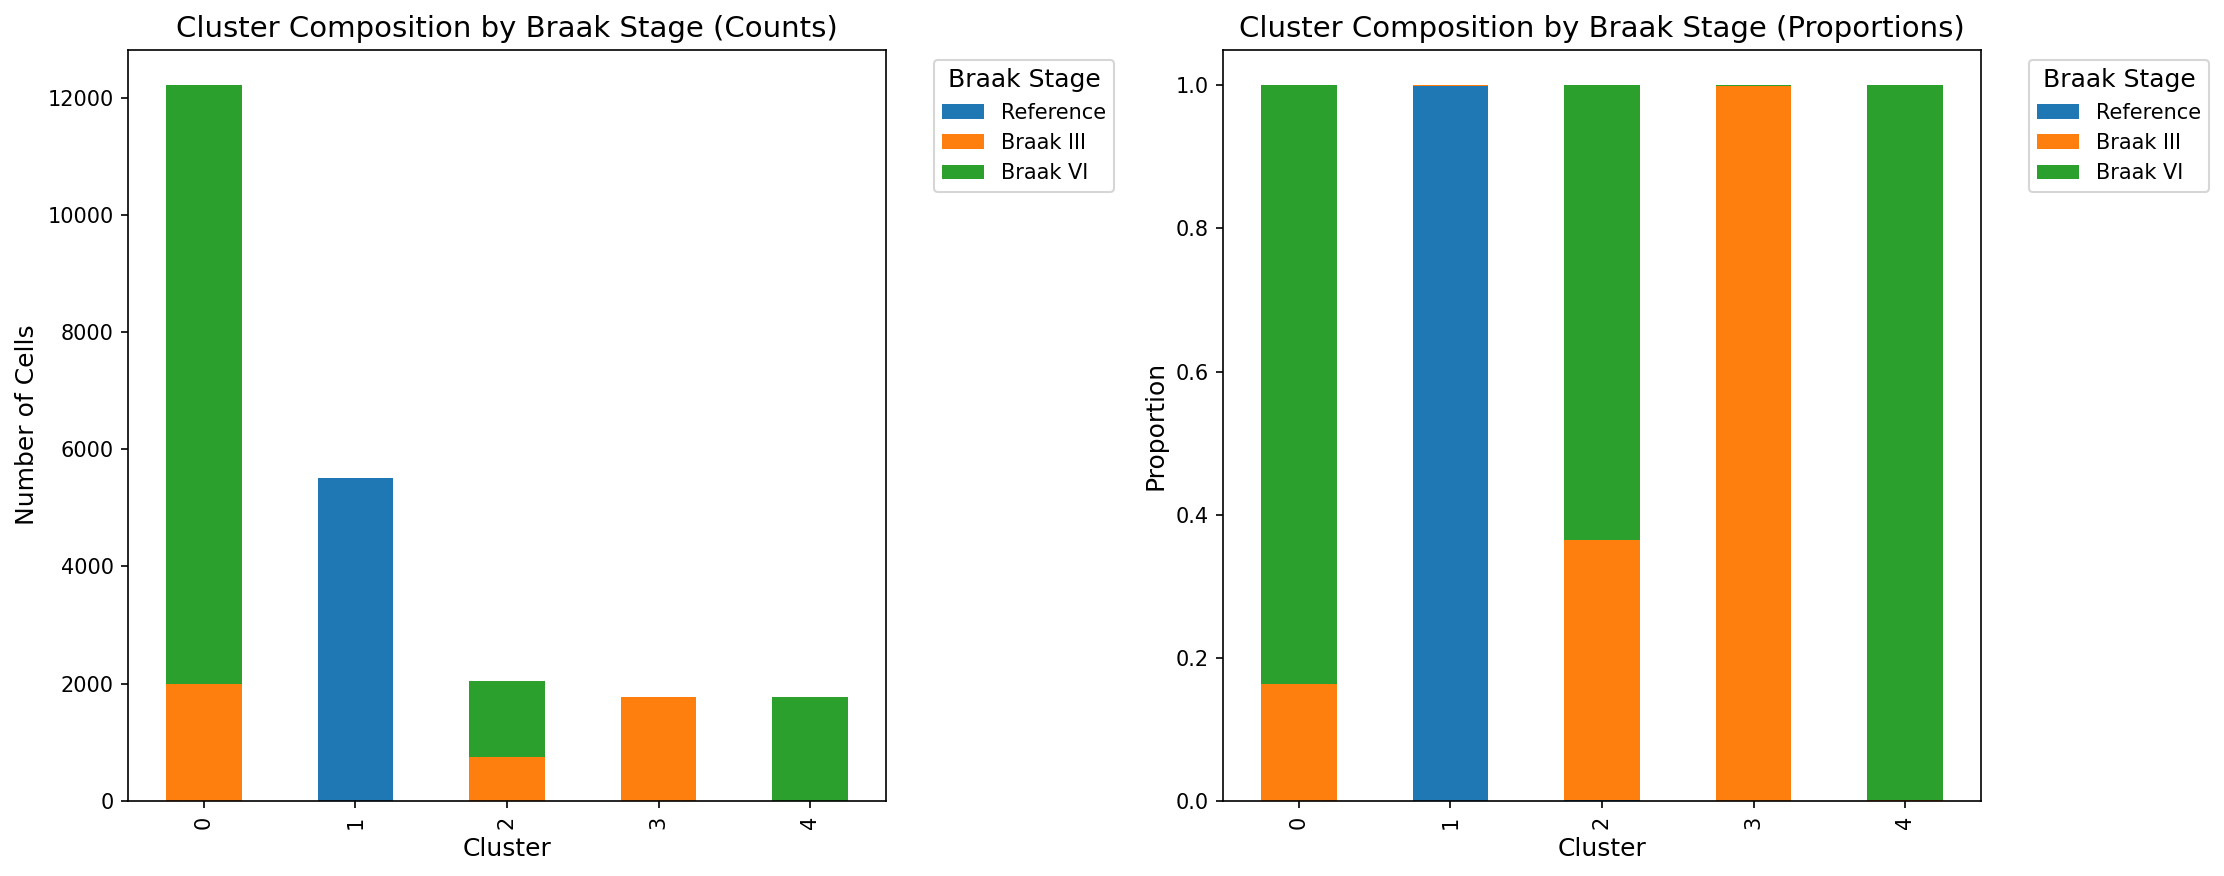


Chi-square test for cluster composition differences:
Chi-square statistic: 31691.2249
P-value: 0.0000e+00
Degrees of freedom: 8
Significant difference in cluster composition between Braak stages (p < 0.05)

Creating UMAP plot colored by Braak stage...


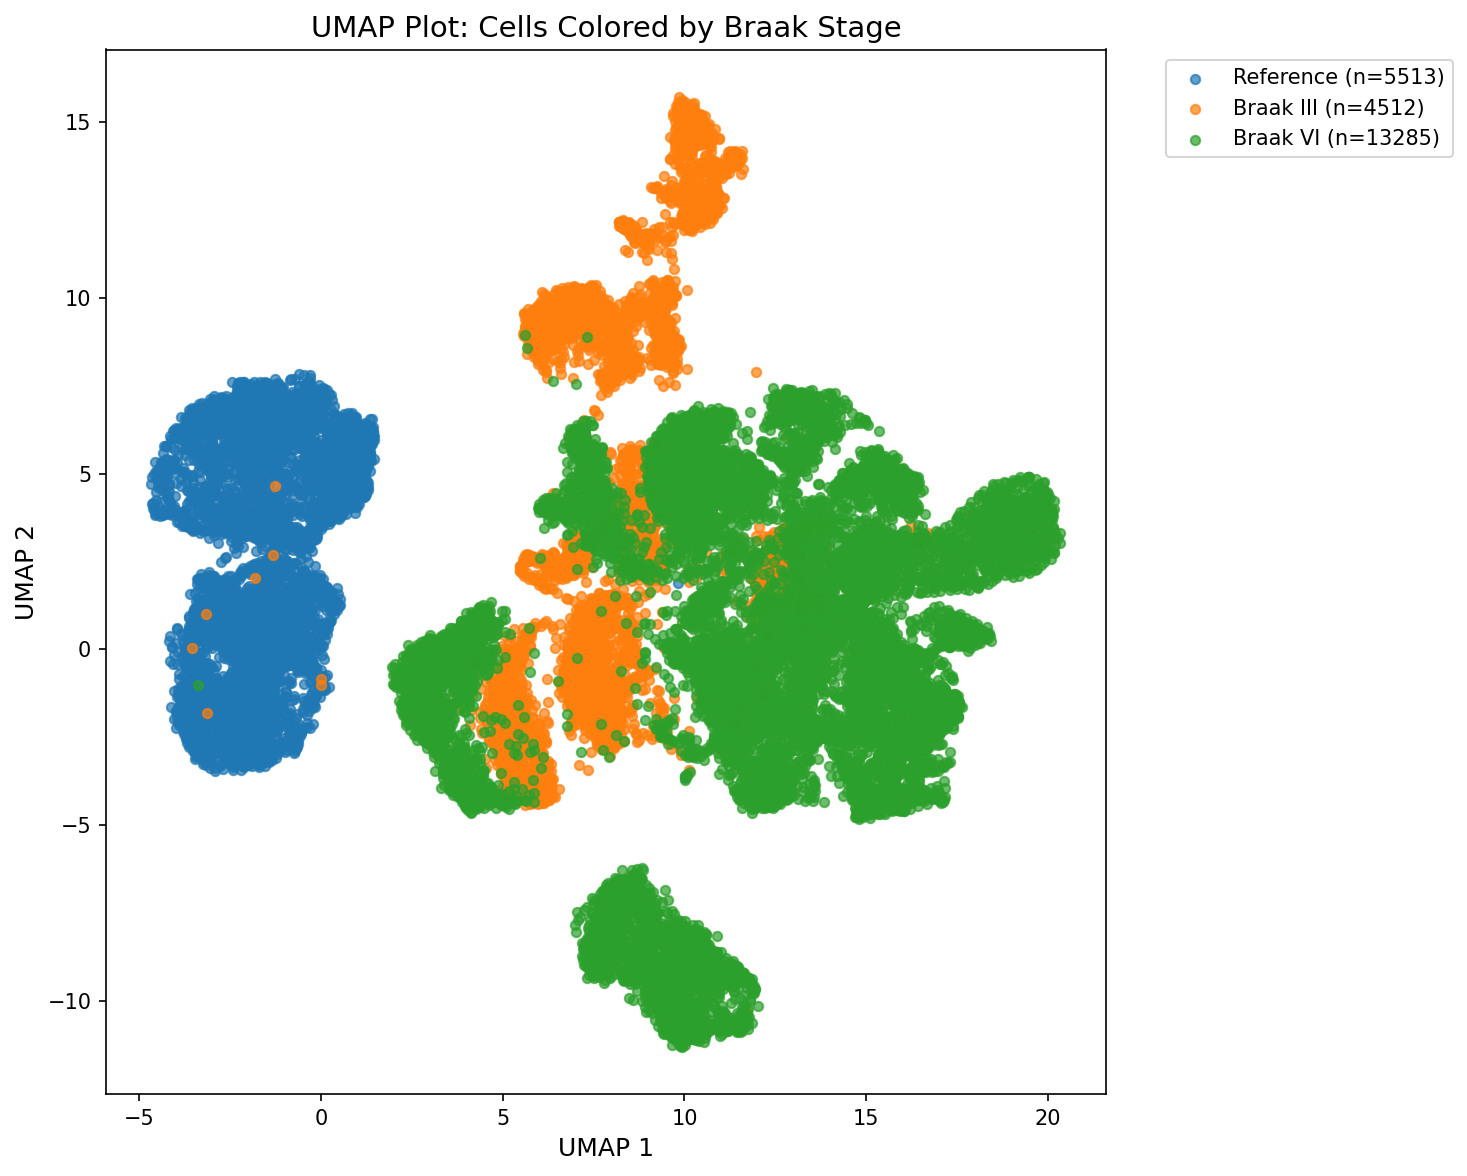

UMAP plot created successfully!


In [9]:
# Analyze cluster composition by Braak stage
print("Analyzing cluster composition by Braak stage...")

if braak_col and 'leiden' in adata.obs.columns:
    # Create a cross-tabulation
    cluster_braak_crosstab = pd.crosstab(adata.obs['leiden'], adata.obs[braak_col])
    print("\nCluster composition by Braak stage:")
    print(cluster_braak_crosstab)
    
    # Calculate proportions
    cluster_braak_prop = pd.crosstab(adata.obs['leiden'], adata.obs[braak_col], normalize='index')
    print("\nCluster composition by Braak stage (proportions):")
    print(cluster_braak_prop)
    
    # Visualize cluster composition
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Absolute counts
    cluster_braak_crosstab.plot(kind='bar', ax=axes[0], stacked=True)
    axes[0].set_title('Cluster Composition by Braak Stage (Counts)')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Cells')
    axes[0].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Proportions
    cluster_braak_prop.plot(kind='bar', ax=axes[1], stacked=True)
    axes[1].set_title('Cluster Composition by Braak Stage (Proportions)')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Proportion')
    axes[1].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test for cluster composition differences
    from scipy.stats import chi2_contingency
    
    chi2, p_value, dof, expected = chi2_contingency(cluster_braak_crosstab)
    print(f"\nChi-square test for cluster composition differences:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4e}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("Significant difference in cluster composition between Braak stages (p < 0.05)")
    else:
        print("No significant difference in cluster composition between Braak stages (p >= 0.05)")

else:
    print("Cannot analyze cluster composition - missing Braak stage or cluster information")

# Create UMAP plot colored by Braak stage
print("\nCreating UMAP plot colored by Braak stage...")
if braak_col and 'X_umap' in adata.obsm:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create color palette for Braak stages
    braak_stages = adata.obs[braak_col].cat.categories
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, stage in enumerate(braak_stages):
        mask = adata.obs[braak_col] == stage
        ax.scatter(adata.obsm['X_umap'][mask, 0], 
                  adata.obsm['X_umap'][mask, 1], 
                  c=colors[i % len(colors)], 
                  label=f'{stage} (n={(mask).sum()})', 
                  alpha=0.7, s=20)
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP Plot: Cells Colored by Braak Stage')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print("UMAP plot created successfully!")
else:
    print("Cannot create UMAP plot - missing UMAP coordinates or Braak stage information")


## Differential Gene Expression Analysis

Perform differential gene expression analysis between Braak stages using gene symbols.


In [ ]:
# Perform differential gene expression analysis
print("Performing differential gene expression analysis...")

# Check if we have the necessary information
if braak_col and adata.raw is not None:
    print(f"Using Braak stage column: {braak_col}")
    print(f"Available Braak stages: {adata.obs[braak_col].unique()}")
    
    # Get unique Braak stages
    unique_braak_stages = adata.obs[braak_col].unique()
    
    # Perform pairwise comparisons
    comparisons = []
    
    # Find Reference and Braak III/VI for comparison (exact matching)
    ref_stage = None
    braak3_stage = None
    braak6_stage = None
    
    for stage in unique_braak_stages:
        stage_str = str(stage)
        if stage_str == "Reference":
            ref_stage = stage
        elif stage_str == "Braak III":
            braak3_stage = stage
        elif stage_str == "Braak VI":
            braak6_stage = stage
    
    print(f"Reference stage: {ref_stage}")
    print(f"Braak III stage: {braak3_stage}")
    print(f"Braak VI stage: {braak6_stage}")
    
    # Set gene symbols as the index for better readability in results
    print(f"\nSetting gene symbols as index for DGE results...")
    # Create a copy with gene symbols as index
    adata_dge = adata.copy()
    adata_dge.var_names = adata_dge.var['feature_name'].values
    
    # Perform comparisons using log-transformed data (not raw counts)
    # Store results for each comparison separately
    dge_results = {}
    
    if ref_stage and braak3_stage:
        print(f"\nComparing {ref_stage} vs {braak3_stage}")
        temp_adata = adata_dge.copy()
        temp_adata.X = adata_dge.layers['log_normalized']  # Use log-transformed data
        sc.tl.rank_genes_groups(temp_adata, braak_col, groups=[braak3_stage], reference=ref_stage, 
                               method='wilcoxon', use_raw=False)  # Use log-transformed data
        dge_results[f"{ref_stage}_vs_{braak3_stage}"] = temp_adata.uns['rank_genes_groups'].copy()
        comparisons.append(f"{ref_stage}_vs_{braak3_stage}")
    
    if braak3_stage and braak6_stage:
        print(f"\nComparing {braak3_stage} vs {braak6_stage}")
        temp_adata = adata_dge.copy()
        temp_adata.X = adata_dge.layers['log_normalized']  # Use log-transformed data
        sc.tl.rank_genes_groups(temp_adata, braak_col, groups=[braak6_stage], reference=braak3_stage, 
                               method='wilcoxon', use_raw=False)  # Use log-transformed data
        dge_results[f"{braak3_stage}_vs_{braak6_stage}"] = temp_adata.uns['rank_genes_groups'].copy()
        comparisons.append(f"{braak3_stage}_vs_{braak6_stage}")
    
    # Store all DGE results in the main adata object
    adata.uns['dge_results'] = dge_results
    # Keep the last comparison in rank_genes_groups for volcano plots
    if dge_results:
        adata.uns['rank_genes_groups'] = list(dge_results.values())[-1]
    
    print(f"Completed {len(comparisons)} comparisons")
    
    # Show cell counts for each stage to verify we have enough cells
    print(f"\nCell counts per Braak stage:")
    for stage in unique_braak_stages:
        count = (adata.obs[braak_col] == stage).sum()
        print(f"  {stage}: {count} cells")
    
else:
    print("Cannot perform DEG analysis - missing Braak stage information or raw data")
    print(f"Braak column: {braak_col}")
    print(f"Raw data available: {adata.raw is not None}")


Performing differential gene expression analysis...
Using Braak stage column: Braak stage
Available Braak stages: ['Braak III', 'Braak VI', 'Reference']
Categories (3, object): ['Reference', 'Braak III', 'Braak VI']
Reference stage: Reference
Braak III stage: Braak III
Braak VI stage: Braak VI

Setting gene symbols as index for DGE results...

Comparing Reference vs Braak III
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)

Comparing Braak III vs Braak VI
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges'

## Volcano Plot Visualization

Create volcano plots to visualize the differential gene expression results with gene symbols.


Creating volcano plots...
Found 2 comparison(s) in results

Creating volcano plot for: Reference vs Braak III


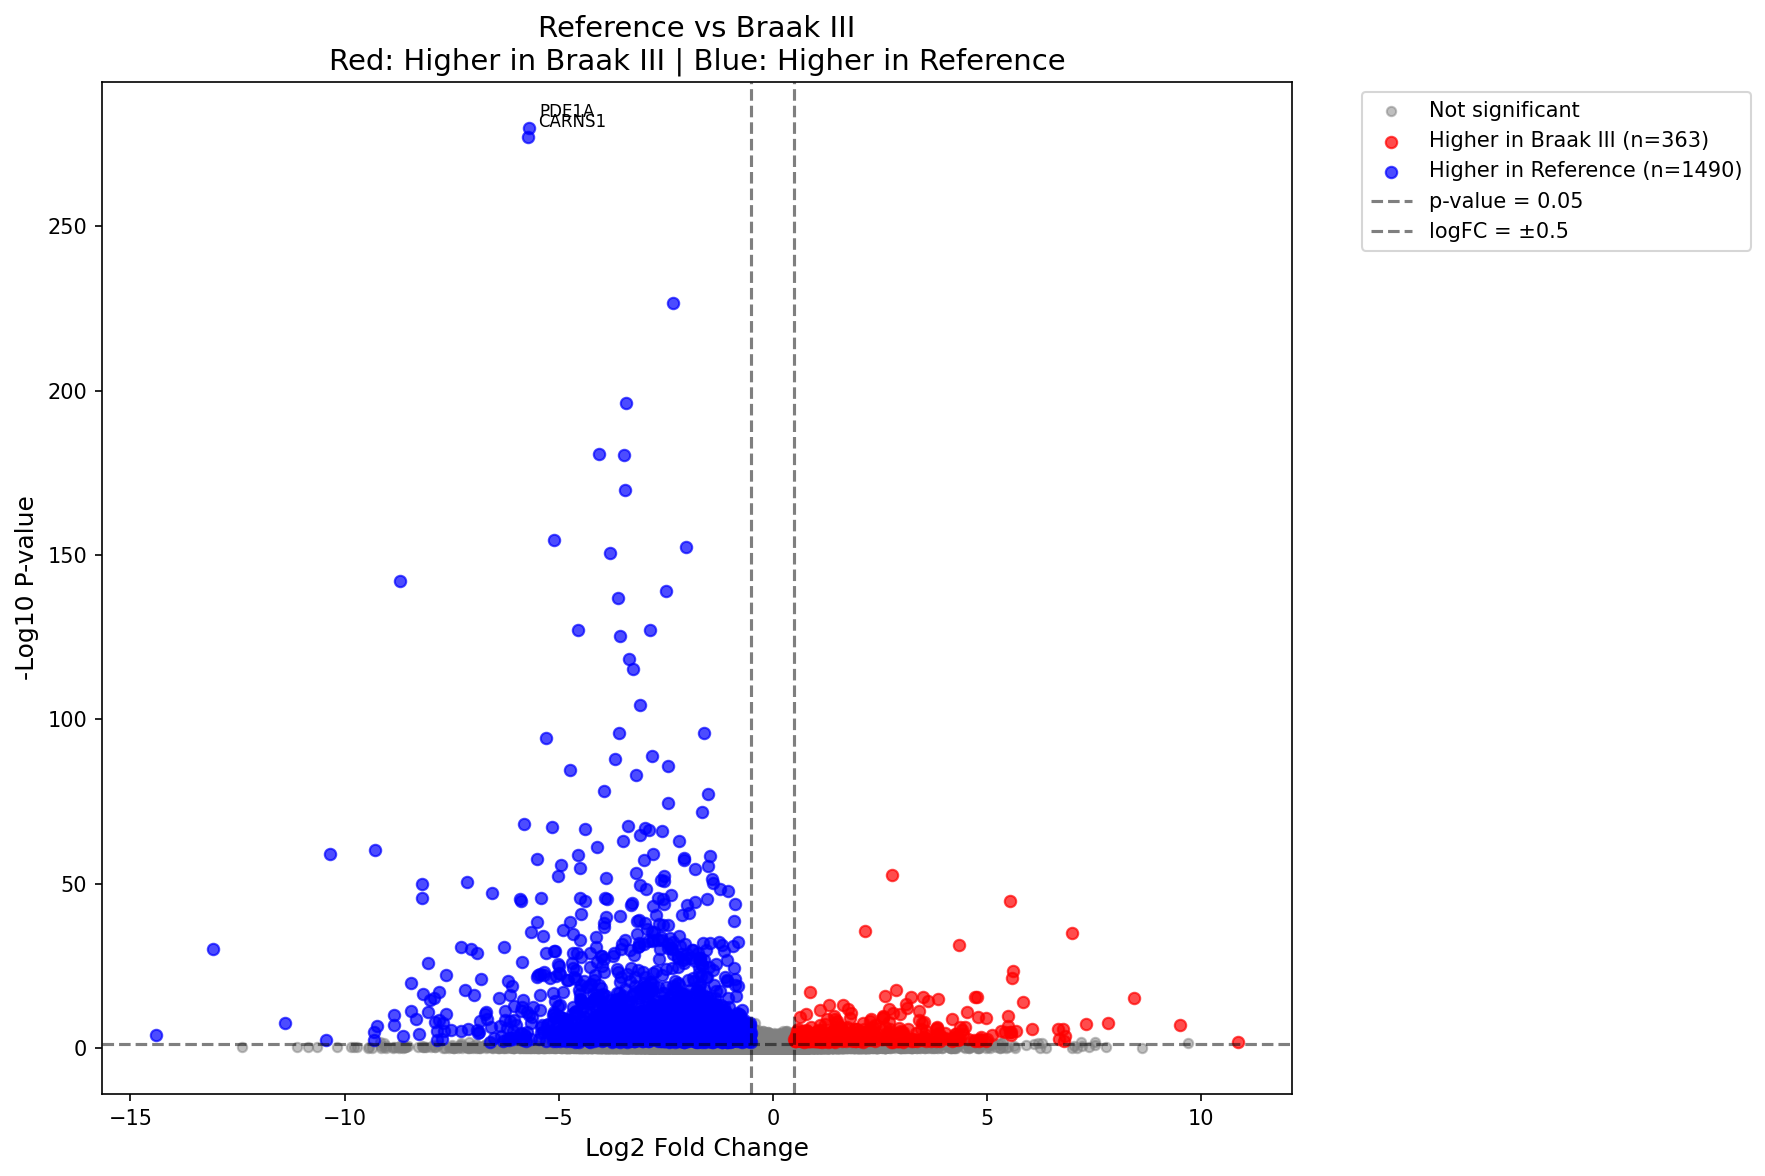


Summary for Reference vs Braak III:
Total genes tested: 24594
Higher in Braak III: 363
Higher in Reference: 1490
Top 5 genes higher in Braak III:
  C12orf60: logFC=10.869, p-val=1.13e-02
  SLC38A9: logFC=9.503, p-val=1.15e-07
  EIF4G3: logFC=8.426, p-val=4.24e-16
  ZCCHC17: logFC=7.821, p-val=3.25e-08
  NSMAF: logFC=7.324, p-val=4.18e-08
Top 5 genes higher in Reference:
  PINX1: logFC=-14.409, p-val=1.24e-04
  NIN: logFC=-13.078, p-val=9.96e-31
  ATPAF2: logFC=-11.398, p-val=1.68e-08
  TNFSF13B: logFC=-10.431, p-val=4.41e-03
  TNRC6B: logFC=-10.329, p-val=6.88e-60

Creating volcano plot for: Braak III vs Braak VI


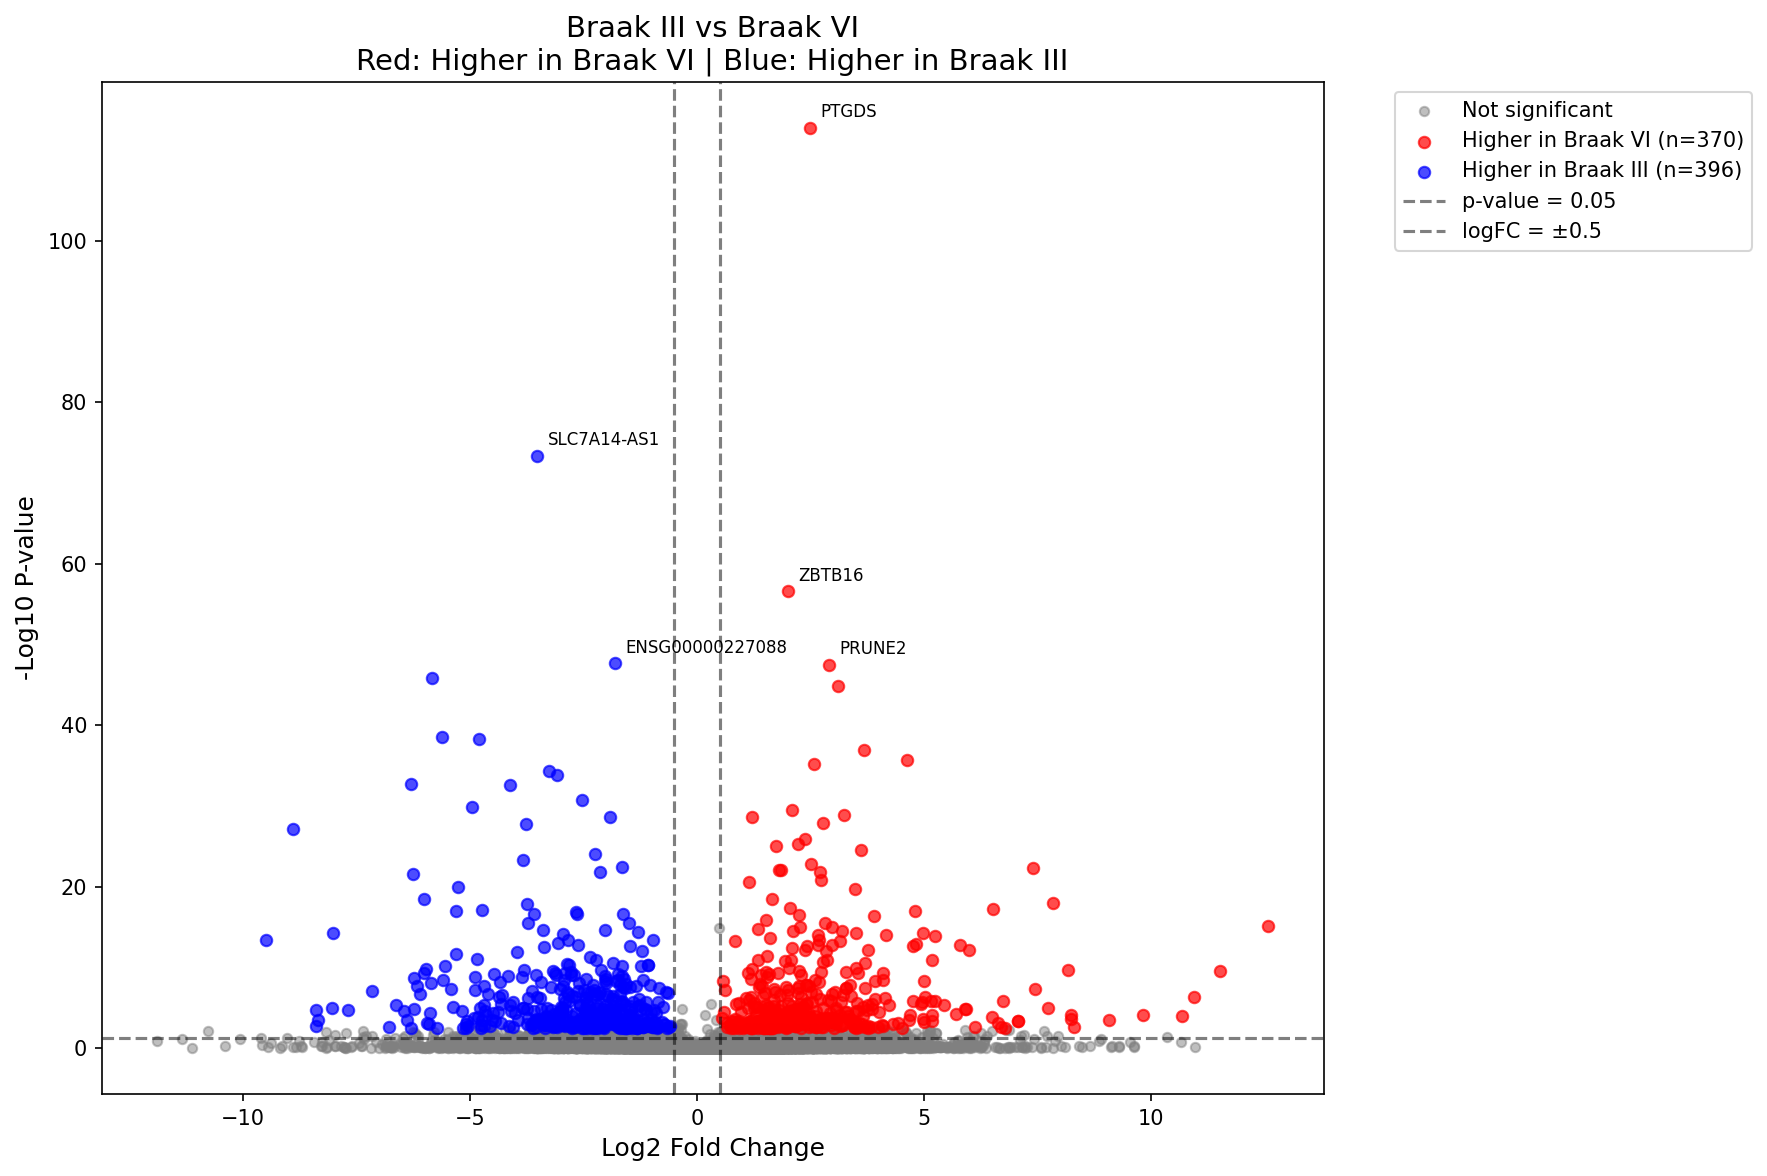


Summary for Braak III vs Braak VI:
Total genes tested: 27950
Higher in Braak VI: 370
Higher in Braak III: 396
Top 5 genes higher in Braak VI:
  ENSG00000229294: logFC=12.578, p-val=7.88e-16
  SNX30: logFC=11.515, p-val=2.49e-10
  SKI: logFC=10.937, p-val=4.66e-07
  C9orf153: logFC=10.688, p-val=1.10e-04
  MT3: logFC=9.827, p-val=8.14e-05
Top 5 genes higher in Braak III:
  PPP1R16B: logFC=-9.506, p-val=4.66e-14
  ZNF506: logFC=-8.896, p-val=7.82e-28
  MYEF2: logFC=-8.392, p-val=1.72e-05
  ZKSCAN8: logFC=-8.389, p-val=1.90e-03
  GNA12: logFC=-8.356, p-val=3.71e-04


In [11]:
# Create volcano plots for differential gene expression results
def create_volcano_plot(adata, comparison_name, group_name, reference_name, pval_thresh=0.05, logfc_thresh=0.5):
    """Create a volcano plot for differential gene expression results with clear direction labels"""
    
    # Get the results
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    
    if len(groups) == 0:
        print(f"No groups found for comparison {comparison_name}")
        return
    
    # Get the first group (should be the comparison group)
    group = groups[0]
    
    # Extract data
    names = result['names'][group]
    logfoldchanges = result['logfoldchanges'][group]
    pvals = result['pvals'][group]
    pvals_adj = result['pvals_adj'][group]
    
    # Create DataFrame
    df = pd.DataFrame({
        'gene': names,
        'logfc': logfoldchanges,
        'pval': pvals,
        'pval_adj': pvals_adj
    })
    
    # Remove NaN values
    df = df.dropna()
    
    # Calculate -log10(p-value)
    df['neg_log10_pval'] = -np.log10(df['pval'])
    
    # Define significance
    df['significant'] = (df['pval_adj'] < pval_thresh) & (np.abs(df['logfc']) > logfc_thresh)
    df['upregulated'] = df['significant'] & (df['logfc'] > 0)
    df['downregulated'] = df['significant'] & (df['logfc'] < 0)
    
    # Create volcano plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot non-significant genes
    ax.scatter(df[~df['significant']]['logfc'], 
               df[~df['significant']]['neg_log10_pval'], 
               c='gray', alpha=0.5, s=20, label='Not significant')
    
    # Plot upregulated genes (higher in comparison group)
    if df['upregulated'].sum() > 0:
        ax.scatter(df[df['upregulated']]['logfc'], 
                   df[df['upregulated']]['neg_log10_pval'], 
                   c='red', alpha=0.7, s=30, label=f'Higher in {group_name} (n={df["upregulated"].sum()})')
    
    # Plot downregulated genes (higher in reference group)
    if df['downregulated'].sum() > 0:
        ax.scatter(df[df['downregulated']]['logfc'], 
                   df[df['downregulated']]['neg_log10_pval'], 
                   c='blue', alpha=0.7, s=30, label=f'Higher in {reference_name} (n={df["downregulated"].sum()})')
    
    # Add threshold lines
    ax.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', alpha=0.5, label=f'p-value = {pval_thresh}')
    ax.axvline(x=logfc_thresh, color='black', linestyle='--', alpha=0.5, label=f'logFC = ±{logfc_thresh}')
    ax.axvline(x=-logfc_thresh, color='black', linestyle='--', alpha=0.5)
    
    # Labels and title with clear comparison
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 P-value')
    ax.set_title(f'{comparison_name}\nRed: Higher in {group_name} | Blue: Higher in {reference_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add gene labels for top genes (should now be gene symbols)
    top_genes = df.nlargest(5, 'neg_log10_pval')
    for _, row in top_genes.iterrows():
        ax.annotate(row['gene'], (row['logfc'], row['neg_log10_pval']), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {comparison_name}:")
    print(f"Total genes tested: {len(df)}")
    print(f"Higher in {group_name}: {df['upregulated'].sum()}")
    print(f"Higher in {reference_name}: {df['downregulated'].sum()}")
    print(f"Top 5 genes higher in {group_name}:")
    top_up = df[df['upregulated']].nlargest(5, 'logfc')
    for _, row in top_up.iterrows():
        print(f"  {row['gene']}: logFC={row['logfc']:.3f}, p-val={row['pval']:.2e}")
    
    print(f"Top 5 genes higher in {reference_name}:")
    top_down = df[df['downregulated']].nsmallest(5, 'logfc')
    for _, row in top_down.iterrows():
        print(f"  {row['gene']}: logFC={row['logfc']:.3f}, p-val={row['pval']:.2e}")
    
    return df

# Create volcano plots for each comparison
if 'dge_results' in adata.uns:
    print("Creating volcano plots...")
    
    # Create plots for each comparison with clear labels
    volcano_results = {}
    
    # Get all comparison results
    dge_results = adata.uns['dge_results']
    
    print(f"Found {len(dge_results)} comparison(s) in results")
    
    for comparison_key, result in dge_results.items():
        groups = result['names'].dtype.names
        
        for group in groups:
            # Create clear comparison names and determine reference
            if "Reference_vs_Braak III" in comparison_key:
                comparison_name = "Reference vs Braak III"
                group_name = "Braak III"
                reference_name = "Reference"
            elif "Braak III_vs_Braak VI" in comparison_key:
                comparison_name = "Braak III vs Braak VI"
                group_name = "Braak VI"
                reference_name = "Braak III"
            else:
                comparison_name = comparison_key
                group_name = str(group)
                reference_name = "Reference"
            
            print(f"\nCreating volcano plot for: {comparison_name}")
            
            # Create a temporary adata with just this comparison
            temp_adata = adata.copy()
            temp_result = {
                'names': result['names'][[group]],
                'logfoldchanges': result['logfoldchanges'][[group]],
                'pvals': result['pvals'][[group]],
                'pvals_adj': result['pvals_adj'][[group]]
            }
            temp_adata.uns['rank_genes_groups'] = temp_result
            
            volcano_df = create_volcano_plot(temp_adata, comparison_name, group_name, reference_name)
            volcano_results[comparison_name] = volcano_df
        
else:
    print("No differential gene expression results found for volcano plots")


## Save Results

Create output folder and save all analysis results.


In [12]:
# Create output directory
output_dir = Path("../output/MTG")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory created: {output_dir.name}")

# Save the processed AnnData object
processed_data_path = output_dir / "processed_MTG_SEA-AD_oligos.h5ad"
adata.write(processed_data_path)
print(f"Saved processed data to: {processed_data_path.name}")

# Save cluster composition results
if braak_col and 'leiden' in adata.obs.columns:
    cluster_braak_crosstab.to_csv(output_dir / "MTG_cluster_braak_composition_counts.csv")
    cluster_braak_prop.to_csv(output_dir / "MTG_cluster_braak_composition_proportions.csv")
    print("Saved cluster composition tables")

# Save differential gene expression results (now with gene symbols)
if 'dge_results' in adata.uns:
    # Save each comparison separately
    dge_results = adata.uns['dge_results']
    
    for comparison_key, result in dge_results.items():
        # Create clean filename from comparison key
        clean_name = comparison_key.replace(" ", "_").replace("vs", "vs")
        comparison_name = f"MTG_deg_results_{clean_name}"
        
        # Get the group from the result
        groups = result['names'].dtype.names
        group = groups[0]  # Should be only one group per comparison
        
        # Create DataFrame for this comparison (gene symbols are now the names)
        deg_df = pd.DataFrame({
            'gene_symbol': result['names'][group],  # Now contains gene symbols
            'logfc': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'scores': result['scores'][group] if 'scores' in result else None
        })
        
        # Add Ensembl IDs back for reference (optional)
        if 'feature_name' in adata.var.columns:
            # Create a mapping from gene symbols to Ensembl IDs
            symbol_to_ensembl = dict(zip(adata.var['feature_name'], adata.var_names))
            deg_df['ensembl_id'] = deg_df['gene_symbol'].map(symbol_to_ensembl)
        
        # Save to CSV
        deg_path = output_dir / f"{comparison_name}.csv"
        deg_df.to_csv(deg_path, index=False)
        print(f"Saved DEG results to: {deg_path.name}")
        
    print(f"Saved {len(dge_results)} differential gene expression comparisons")

print("All results saved successfully!")


Output directory created: MTG
Saved processed data to: processed_MTG_SEA-AD_oligos.h5ad
Saved cluster composition tables
Saved DEG results to: MTG_deg_results_Reference_vs_Braak_III.csv
Saved DEG results to: MTG_deg_results_Braak_III_vs_Braak_VI.csv
Saved 2 differential gene expression comparisons
All results saved successfully!


## Summary

This notebook has completed the following analyses:

1. ✅ Loaded and inspected the OLIGO_MTG_SEA-AD.h5ad dataset
2. ✅ Checked data normalization status and raw data availability
3. ✅ Filtered data for Braak stages: Reference, Braak III, and Braak VI
4. ✅ Performed standard Scanpy processing (if raw counts detected)
5. ✅ Analyzed cluster composition by Braak stage with statistical testing
6. ✅ Performed differential gene expression analysis between Braak stages using gene symbols
7. ✅ Created volcano plots for visualization with gene symbols
8. ✅ Saved all results to the output/MTG folder

### Key Files Generated:
- `processed_MTG_SEA-AD_oligos.h5ad`: Processed AnnData object
- `MTG_cluster_braak_composition_counts.csv`: Cluster composition counts
- `MTG_cluster_braak_composition_proportions.csv`: Cluster composition proportions
- `MTG_deg_results_[comparison].csv`: Differential gene expression results for each comparison

### Next Steps:
- Review the volcano plots for biologically relevant genes
- Perform pathway enrichment analysis on significant DEGs
- Validate findings with additional datasets or experimental approaches
